In [3]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [4]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.




# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from skimage import exposure
import numpy as np
import imutils
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import random
import seaborn as sns
import time

log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
rndm_state = 42

In [5]:
compute_mode = 'gpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

# Attacking an ML-model





Loading data:

In [6]:

root = './data'
if not os.path.exists(root):
    os.mkdir(root)
trans = transforms.Compose([transforms.ToTensor()])

# if not exist, download mnist dataset
x_trainval_n = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True) 

y_trainval_n = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True) 

x_trainval_nf = (x_trainval_n.data).cpu().detach().numpy()


y_trainval = (x_trainval_n.targets).cpu().detach().numpy()  # tensor to np.array

x_test_nf =   (y_trainval_n.data).cpu().detach().numpy() 

y_test = (y_trainval_n.targets).cpu().detach().numpy()   # tensor to np.array

(x_trainval_nf, x_eval_nf_g, y_trainval, y_eval_g) = train_test_split(x_trainval_nf, y_trainval,
	test_size=0.1, random_state=84)

print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval_nf.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test_nf.shape, y_test.shape))
print(x_eval_nf_g.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

x_trainval.shape = (54000, 28, 28),  y_trainval.shape = (54000,)
x_test.shape = (10000, 28, 28),  y_test.shape = (10000,)
(6000, 28, 28)


Defining parameters:

In [7]:
input_size =  1
hidden_layers = [20,144]
num_classes = 10
num_epochs = 10
batch_size = 2000
learning_rate = 0.001
learning_rate_decay = 0.95
reg= 0.001
num_training= 50000
num_validation =10000
dropout = "yes"

val_accu = []
val_accu_data = 0
last = 0
loss_ar = []
valid_losses = []
count =0
valid_losses_sum = 0
train_accu = []
correct_train = 0
total_train = 0
best_accuracy = 0
loss_values = []


test_set = 'val'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation
if test_set == 'val':
    mask = list(range(num_training))
    train_dataset = torch.utils.data.Subset(x_trainval_n, mask)
    mask = list(range(num_training, num_training + num_validation))
    val_dataset = torch.utils.data.Subset(x_trainval_n, mask) 
else:
    y_trainval_n = y_trainval_n
 

Data Loader:

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_loader_nn = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader_nn = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader_nn = torch.utils.data.DataLoader(dataset=y_trainval_n,
                                          batch_size=batch_size,
                                          shuffle=False)

# subset_indices = [0] # select your indices here as a list
subset_indices = list(range(0, 3000, 1))#y_trainval_n
subset = torch.utils.data.Subset(y_trainval_n, subset_indices)
test_loader_nn_subset = torch.utils.data.DataLoader(dataset=subset,
                                          batch_size=1,
                                          shuffle=False)

cuda


Defining model:

In [9]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, dropout):
        super(Net, self).__init__()
        self.layers = []
        if dropout == "no":
          self.layers.append(nn.Conv2d(input_size,hidden_layers[0],5))
          self.layers.append(nn.ReLU())
          self.layers.append(nn.MaxPool2d(stride = 1, kernel_size = 2))
          self.layers.append(nn.Conv2d(hidden_layers[0],hidden_layers[1],5))
          self.layers.append(nn.ReLU())
          self.layers.append(nn.MaxPool2d(kernel_size = 2, stride = 1))
          #self.layers.append(nn.Linear(hidden_layers[1],num_classes))
          self.layers = nn.Sequential(*self.layers)
          #self.f = nn.flatten()
          self.fc = nn.Sequential(nn.Linear(46656,num_classes))
          # self.fc2 = nn.Sequential(nn.Softmax())
          self.fullnn = [self.layers,self.fc]
        else:
          self.layers.append(nn.Conv2d(input_size,hidden_layers[0],5))
          self.layers.append(nn.ReLU())
          self.layers.append(nn.MaxPool2d(stride = 1, kernel_size = 2))
          self.layers.append(nn.Dropout(0.5))
          self.layers.append(nn.Conv2d(hidden_layers[0],hidden_layers[1],5))
          self.layers.append(nn.ReLU())
          self.layers.append(nn.MaxPool2d(kernel_size = 2, stride = 1))
          self.layers.append(nn.Dropout(0.5))
          #self.layers.append(nn.Linear(hidden_layers[1],num_classes))
          self.layers = nn.Sequential(*self.layers)
          #self.f = nn.flatten()
          self.fc = nn.Sequential(nn.Linear(46656,num_classes))
          # self.fc2 = nn.Sequential(nn.Softmax())
          self.fullnn = [self.layers,self.fc]

    def forward(self, x):
     
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        out1 = (self.fc(x))
      
        return out1

Weight Initialization function and learning rate update function:

In [10]:
#initialization of weights for conv2d layers

def weights_init(m):
    if type(m) == nn.Conv2d:
        m.weight.data.normal_(0.0, 1e-3)

#update learning rate after one step of backprop        
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr 

Model creation:

In [11]:
model = Net(input_size, hidden_layers, num_classes, dropout).to(device)

Test function for model accuracy:

In [12]:
def test_nn(test_loader_nn,model):
   
   with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_nn:
          
          images = images.to(device)
         
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
          # if total == 1000:
          #     break

      print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))
   return predicted

Loading the best model from Task 1:

In [13]:
model_name = "best_modelyes_after"
model = Net(input_size, hidden_layers, num_classes, dropout).to(device)
model.load_state_dict(torch.load(str(model_name)+'.ckpt'))

<All keys matched successfully>

Test accuracy score for loaded model:

In [14]:
predicted = test_nn(test_loader_nn,model)

Accuracy of the network on the 10000 test images: 98.39 %


Our best model from Task 1 achieved 98.39% accuracy. We will use the same model for the below FGSM attack.

## Implementing the FGSM attack (7 Points)



More details: https://arxiv.org/pdf/1412.6572.pdf


Defining Epsilons:
We keep 0 value in the list to represent the model performance on the original test set.

In [52]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

FGSM function:

In [26]:
def fgsm_attack(image, epsilon, data_grad):
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # Create the perturbed image
    perturbed_image = image + epsilon*sign_data_grad
    
    # Maintain [0,255] range
    perturbed_image = torch.clamp(perturbed_image, 0, 255)

    return perturbed_image

Adversarial Test function:

In [27]:
def test( model, device, test_loader, epsilon ):

    correct = 0
    adv_examples = []
    criterion = nn.CrossEntropyLoss()

    for data, target in test_loader:

        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        # Forward pass
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        # Don't attack if the initial prediction is wrong
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # New prediction
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

##  Adversarial sample set



Calculating the test accuracies on the generated adversarial images over the different epsilon values:

In [61]:
accuracies = []
examples = []
time_s = []
# Run test for each epsilon
for eps in epsilons:
    start = time.time()
    acc, ex = test(model, device, test_loader_nn_subset, eps)
    stop = time.time()
    accuracies.append(acc)
    time_s.append(stop-start)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 2909 / 3000 = 0.9696666666666667
Epsilon: 0.05	Test Accuracy = 2768 / 3000 = 0.9226666666666666
Epsilon: 0.1	Test Accuracy = 2382 / 3000 = 0.794
Epsilon: 0.15	Test Accuracy = 1595 / 3000 = 0.5316666666666666
Epsilon: 0.2	Test Accuracy = 719 / 3000 = 0.23966666666666667
Epsilon: 0.25	Test Accuracy = 253 / 3000 = 0.08433333333333333
Epsilon: 0.3	Test Accuracy = 89 / 3000 = 0.029666666666666668


Plotting Accuracies vs Epsilon for undefended model under FGSM attack:

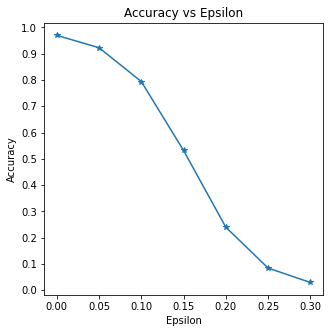

In [62]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

##  Visualizing the results 


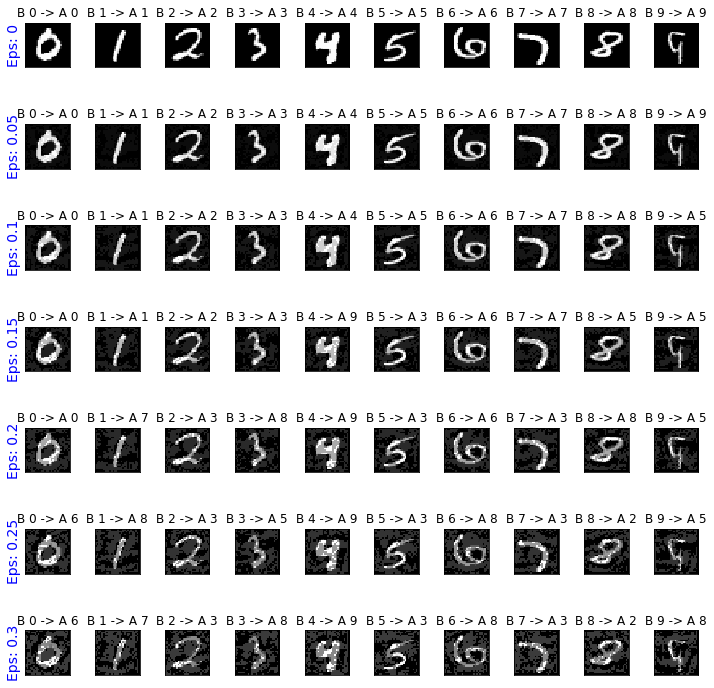

In [63]:
cnt = 0
plt.figure(figsize=(10,10))
eps_ex = []
o_ex = []
for i in range(len(epsilons)):
    plt_cnt = 0
    for j in range(len(examples[i])):
        orig,adv,ex = examples[i][j]
        if i == 4:
          eps_ex.append(ex)
          o_ex.append(int(orig))
        if (orig == plt_cnt) & (plt_cnt<10):
          cnt += 1
          plt.subplot(len(epsilons),10,cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if plt_cnt == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14, color = 'b')
          plt.title("B {} -> A {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
          plt_cnt+=1
        elif (plt_cnt>=10):
          break
plt.tight_layout()
plt.show()

Plotting computation time of the attack for each epsilon value:

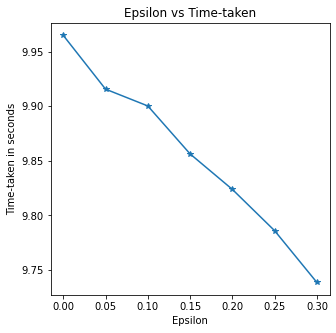

In [64]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, time_s, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Epsilon vs Time-taken")
plt.xlabel("Epsilon")
plt.ylabel("Time-taken in seconds")
plt.show()

##  Analyzing the results




**Findings**

1. From the above "*Accuracy vs Epsilon*" graph it is evident that with increase in pertubation budget the model accuracy will decrease, but if the budget becomes too large the pertubation images become too obvious visually. That occurs because if epsilon increases it means larger steps are taken in the direction that will maximize the loss.

> We can also notice that even though our epsilon values are linearly spaced, the curve is not linear. For instance, the accuracy difference between 0.15 and 0.2 seems higher than the difference between epislons 0.05 and 0.1.

2. From the above "*Epsilon vs Time-taken*" graph, computation cost for the pertubation budgets don't vary much and is around 10 seconds.

3. In this case, the FGSM attack is a white-box attack as we need knowledge and access to the model for calculating gradients of the loss w.r.t the input image. However, we could also use methods like ensembles of different models to approximate the original one without accessing it.

4. With increasing pertubation budget we can see that the noise in the image is easily visible and it defeats the point of attack, which meant to be a small change in appearance of image which leads to incorrect classification.

# Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. 


##  Implementing the adversarial training defense 

Loading the undefended model for adversarial training:

In [ ]:
model_name = "best_modelyes_after"
model_adv = Net(input_size, hidden_layers, num_classes, dropout).to(device)
model_adv.load_state_dict(torch.load(str(model_name)+'.ckpt'))

<All keys matched successfully>

Adversarial Training function:

In [33]:
def train_model_adv(dropout_s,model,learning_rate,reg,train_loader_nn,val_loader_nn,best_accuracy,num_epochs,total_train,correct_train,train_acc,val_accu_data,val_accu,learning_rate_decay,train_accu,loss_values,model_name):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
    lr = learning_rate
    total_step = len(train_loader_nn)
    
    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(train_loader_nn):

           images = images.to(device)
           labels = labels.to(device)
           images.requires_grad = True
        
           # Normal training 

           # Forward pass
           outputs = model(images)
           loss = criterion(outputs, labels)
        
           # Backward and optimize
           optimizer.zero_grad()
           loss.backward()
           optimizer.step()
        
           # Adverserial training 
          
           data_grad = images.grad.data
           perturbed_data = fgsm_attack(images, random.choice(epsilons[1:5]), data_grad) #Randomly choosing epsilon values from 0.05 to 0.2 as suggested above in one of the papers
           
           # Forward pass
           outputs = model(perturbed_data)
           loss = criterion(outputs, labels)
          
           optimizer.zero_grad()
           loss.backward()
           optimizer.step()
           
           loss_ar.append(loss.item())

           if (i+1) % 25 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
              _, predicted_train = torch.max(outputs.data, 1)
              loss_values.append(loss.item())
              total_train += labels.size(0)
              correct_train += (predicted_train == labels).sum().item() 
              # print(total_train,correct_train) 


        train_accu.append(100 * correct_train / total_train)
        correct_train = 0
        total_train = 0

        # Update the learning rate
        lr *= learning_rate_decay
        update_lr(optimizer, lr)
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader_nn:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            print('Validataion accuracy is: {} %'.format(100 * correct / total))
            val_accu_data = (100 * correct) / total
            #print(type(val_accu))
            val_accu.append(val_accu_data)
             

        model.train()

    if(val_accu[num_epochs-1]> best_accuracy):
        best_accuracy = val_accu[num_epochs-1]
        torch.save(model.state_dict(),str(model_name)+'.ckpt')                         
        print("best model with val acc"+ str(val_accu[num_epochs-1])+ "is saved")
    return   val_accu,val_accu[num_epochs-1],train_accu,best_accuracy,loss_values


Adversarial training procedure:

In [34]:
dropout_s = 'yes'
model_name = "model_adv"
val_acc_list,val_accu,train_accu, best, loss_history = train_model_adv(dropout_s,model_adv,learning_rate,reg,train_loader_nn,val_loader_nn,best_accuracy,num_epochs,total_train,correct_train,train_accu,val_accu_data,val_accu,learning_rate_decay,train_accu,loss_values,model_name)



Epoch [1/10], Step [25/25], Loss: 0.9417
Validataion accuracy is: 95.68 %
Epoch [2/10], Step [25/25], Loss: 0.3563
Validataion accuracy is: 97.91 %
Epoch [3/10], Step [25/25], Loss: 0.2794
Validataion accuracy is: 98.26 %
Epoch [4/10], Step [25/25], Loss: 0.4119
Validataion accuracy is: 98.52 %
Epoch [5/10], Step [25/25], Loss: 0.4047
Validataion accuracy is: 98.35 %
Epoch [6/10], Step [25/25], Loss: 0.1716
Validataion accuracy is: 98.72 %
Epoch [7/10], Step [25/25], Loss: 0.1791
Validataion accuracy is: 98.76 %
Epoch [8/10], Step [25/25], Loss: 0.4308
Validataion accuracy is: 98.85 %
Epoch [9/10], Step [25/25], Loss: 0.1440
Validataion accuracy is: 98.96 %
Epoch [10/10], Step [25/25], Loss: 0.2773
Validataion accuracy is: 98.98 %
best model with val acc98.98is saved


Testing of clean images on defended model:

In [35]:
predicted = test_nn(test_loader_nn,model_adv)

Accuracy of the network on the 10000 test images: 98.76 %


##  Evaluation 

During the adversarial training we use random values of epsilons among 0.05 and 0.2. For testing the defended model on adversarial images we use 0.15 as **lower budget** and 0.3 as **higher budget**:

In [36]:
accuracies_adv = []
examples = []

# Run test for each epsilon
for eps in [0.15,0.3]:
    acc, ex = test(model_adv, device, test_loader_nn_subset, eps)
    accuracies_adv.append(acc)
    examples.append(ex)

Epsilon: 0.15	Test Accuracy = 2662 / 3000 = 0.8873333333333333
Epsilon: 0.3	Test Accuracy = 1467 / 3000 = 0.489


Comparing accuracies of undefended model and defended model for pertubation budget of 0.15 and 0.3:

In [37]:

print('Accuracy on the lower-budget(epsilon = 0.15) adversarial samples (FGSM) %.3f'%accuracies[3])
print('Accuracy on the lower-budget (epsilon = 0.15) adversarial samples (FGSM) after defense %.3f'%accuracies_adv[0])

print('Accuracy on the higher-budget (epsilon = 0.30) adversarial samples (FGSM) %.3f'%accuracies[6])
print('Accuracy on the higher-budget (epsilon = 0.30) adversarial samples (FGSM) after defense %.3f'%accuracies_adv[1])

Accuracy on the lower-budget(epsilon = 0.15) adversarial samples (FGSM) 0.537
Accuracy on the lower-budget (epsilon = 0.15) adversarial samples (FGSM) after defense 0.887
Accuracy on the higher-budget (epsilon = 0.30) adversarial samples (FGSM) 0.036
Accuracy on the higher-budget (epsilon = 0.30) adversarial samples (FGSM) after defense 0.489


**Findings**

> We can notice the defense against the attack was succesfull for both the pertubation budgets, as the accuracy after defense is higher in both cases. The difference is due to the adversarial training.

> For lower pertubation compared to the pertubation budget used in the training the accuracy was nearer to the accuracy of clean data, where as for the higher pertubation budget compared to the pertubation budget used in the training the accuracy is still far away from the accuracy of clean data.

> It is expected that for the higher budget the accuracy in low even after the defense, as we already mentioned, larger epsilons mean we take a larger step in the direction that will maximize the loss.  

> For the adversarial images generated with the pertubation budget 0.15, one cannot perceive the noise in the images. On the other hand, for the images generated with the budget 0.3, the perturbation becomes evident. Refer to section 1.4: Visualizing the results to check the difference.



# I-FGSM attack  

* FGSM is one of the simplest and earliest attacks. Since then, many more advanced attacks have been proposed. 
* One of them is the Iterative-FGSM (https://arxiv.org/pdf/1607.02533.pdf), where the attack is repeated multiple times.
* In this part, we ask you to please implement the iterative FGSM attack. 



##  Implementing the I-FGSM attack 


Implementing the I-FGSM function

In [38]:
def i_fgsm_attack(model,criterion,image,target, epsilon,alpha):
    # iterations = int(min(epsilon + 4, 1.25*epsilon))
    iterations = 10
    for i in range(iterations):
      image.requires_grad = True
      outputs = model(image)

      model.zero_grad()
      cost = criterion(outputs, target).to(device)
      cost.backward()

      # Collect the element-wise sign of the data gradient
     
      # Create the perturbed image by adjusting each pixel of the input image
      perturbed_image = image + alpha*image.grad.sign()

      # Adding clipping to maintain [0,255] range
      # a = max{0, X-eps}
      a = torch.clamp(image - epsilon, min=0)
      
      # b = max{a, X'}
      b = (perturbed_image>=a).float()*perturbed_image + (a>perturbed_image).float()*a
      
      # c = min{X+eps, b}
      c = (b > image+epsilon).float()*(image+epsilon) + (image+epsilon >= b).float()*b
      
      # d = min{255, c}
      perturbed_image = torch.clamp(c, max=255).detach_()
      image = perturbed_image
  
    return image

##  Attack the undefended model 

* We will first attack the **undefended model** (i.e., without adversarial training).

* Choose one perturbation budget from Question **1.3** for comparison. 

    * Hint: A simple way to choose the small step is to divide the total budget by the number of steps (e.g., 10).

* Please generate 1000 adversarial examples using the **undefended** model and the **I-FGSM** you implemented. 

* Please compute the accuracy of the adversarial set on the **undefended** model. 

Test function for I-FGSM attack:

In [75]:
def test_i_fgsm( model, device, test_loader, epsilon ):
    criterion = nn.CrossEntropyLoss()
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        # Don't attack if the initial prediction is wrong
        if init_pred.item() != target.item():
            continue

        # I-FGSM Attack
        alpha= 0.015
        perturbed_data = i_fgsm_attack(model,criterion,data,target, epsilon,alpha)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


Loading the undefended model:

In [72]:
model_name = "best_modelyes_after"
model = Net(input_size, hidden_layers, num_classes, dropout).to(device)
model.load_state_dict(torch.load(str(model_name)+'.ckpt'))

<All keys matched successfully>

Testing accuracies for the undefended model on adversarial images generated using I-FGSM:

In [76]:
accuracies_i = []
examples_i = []
time_i = []
# Run test for each epsilon
for eps in epsilons:
    start = time.time()
    acc, ex = test_i_fgsm(model, device, test_loader_nn_subset, eps)
    stop = time.time()
    time_i.append(stop-start)
    accuracies_i.append(acc)
    examples_i.append(ex)

Epsilon: 0	Test Accuracy = 2907 / 3000 = 0.969
Epsilon: 0.05	Test Accuracy = 1414 / 3000 = 0.4713333333333333
Epsilon: 0.1	Test Accuracy = 1414 / 3000 = 0.4713333333333333
Epsilon: 0.15	Test Accuracy = 1439 / 3000 = 0.4796666666666667
Epsilon: 0.2	Test Accuracy = 1431 / 3000 = 0.477
Epsilon: 0.25	Test Accuracy = 1395 / 3000 = 0.465
Epsilon: 0.3	Test Accuracy = 1426 / 3000 = 0.47533333333333333


Plot class adversarial samples at each epsilon value and the predicted label before (B) and after (A) the iterative attack:

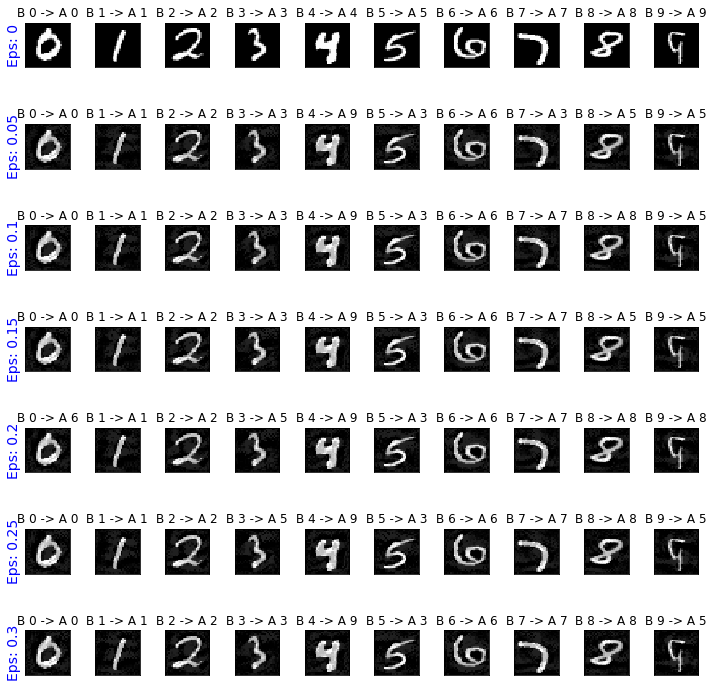

In [77]:
cnt = 0
plt.figure(figsize=(10,10))
eps_ex = []
o_ex = []
for i in range(len(epsilons)):
    plt_cnt = 0
    for j in range(len(examples_i[i])):
        orig,adv,ex = examples_i[i][j]
        if i == 4:
          eps_ex.append(ex)
          o_ex.append(int(orig))
        if (orig == plt_cnt) & (plt_cnt<10):
          cnt += 1
          plt.subplot(len(epsilons),10,cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if plt_cnt == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14, color = 'b')
          plt.title("B {} -> A {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
          plt_cnt+=1
        elif (plt_cnt>=10):
          break
plt.tight_layout()
plt.show()

### Findings and comparison with FGSM 

**Findings**

> The attack was successfull for lower values of epsilon, however, as we increase epsilon, it is unable to improve and remains same.

> We can notice that I-FGSM generates finer perturbations which do not destroy the image even with higher epsilon values (See 1.4: Visualizing the results).

> When we increase the number of steps, the accuracy of the model against the attack decreases drastically even for lower epsilon values and remains saturated until higher values.

**For 10 steps:**

Epsilon   | Test Accuracy 
----------|------------------
0         | 0.969 
0.05      | 0.4713333333333333
0.1       | 0.4713333333333333 
0.15      | 0.4796666666666667 
0.2       | 0.477 
0.25      | 0.465 
0.3       | 0.47533333333333333  
 
**For 20 steps:**

Epsilon   | Test Accuracy 
----------|------------------
0         | 0.9673333333333334 
0.05      | 0.002
0.1       | 0.004 
0.15      | 0.0036666666666666666 
0.2       | 0.0036666666666666666 
0.25      | 0.004  
0.3       | 0.004333333333333333  

> We tried different alpha values and we found that increasing it represent a greater distortion in the image, which leads to decrease the accuracy drastically, for instance, for alpha 0.1 we get 0 accuracy even for the smalles epsilon value. We took alpha value as 0.015, considering our epsilon values by the number of iterations.


> As we can see in the below figure, while comparing to the different attacks, I-FGSM performs better for lower epsilon values, whereas as epsilon increases, it does not have much effect on attack efficiency. On the other hand, FGSM performs better with higher epsilon values.

> As it is expected, computation time for I-FGSM is greater than that of the FGSM, since there are iterations involved in it. The same behaviour is plotted below, in our case, with 10 iterations, I-FGSM takes around seven times more than computation of FGSM.

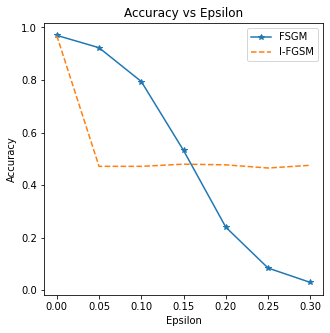

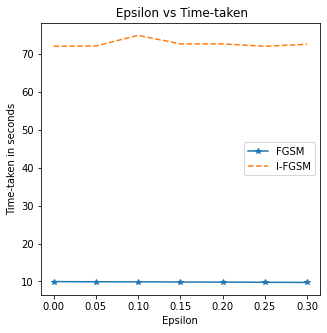

In [78]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-",label = "FSGM")
plt.plot(epsilons,accuracies_i,"--",label = "I-FGSM")
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


plt.figure(figsize=(5,5))
plt.plot(epsilons, time_s, "*-",label = "FGSM")
plt.plot(epsilons, time_i, "--", label = "I-FGSM")
plt.title(" Epsilon vs Time-taken")
plt.xlabel("Epsilon")
plt.ylabel("Time-taken in seconds")
plt.legend()
plt.show()

## Attack the defended model


Loading the defended model which we got from FGSM adversarial training:

In [79]:
model_name = "model_adv"
model_adv = Net(input_size, hidden_layers, num_classes, dropout).to(device)
model_adv.load_state_dict(torch.load(str(model_name)+'.ckpt'))

<All keys matched successfully>

In [44]:
accuracies_adv_i = []
examples_adv_i = []

# Run test for each epsilon
for eps in [0.15,0.3]:
    acc, ex = test_i_fgsm(model_adv, device, test_loader_nn_subset, eps)
    accuracies_adv_i.append(acc)
    examples_adv_i.append(ex)

Epsilon: 0.15	Test Accuracy = 2556 / 3000 = 0.852
Epsilon: 0.3	Test Accuracy = 2567 / 3000 = 0.8556666666666667


**Results**

The attack was not effective against the defended model. 

I-FGSM attack works better for lower epsilon values when compared to FGSM whereas when the epsilon value increases the FGSM performs better.

To improve the defence against I-FGSM, the model should have adversarial training with I-FGSM, generated adversarial images of lower epsilon values whereas for higher values of epsilon we should use FGSM generated adversarial images for adversarial training.

As we can see below that, even if the accuracy of model is less, the images generated from I-FGSM attack has less noise and hardly can be distinguished from clean data which is the original intension of the attack.

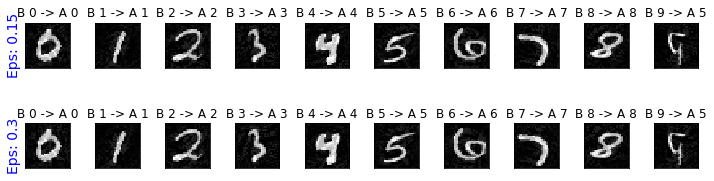

In [49]:
epsilons = [0.15,0.3]
cnt = 0

eps_ex = []
o_ex = []
plt.figure(figsize=(10,3))
for i in range(len(epsilons)):
    plt_cnt = 0
    for j in range(len(examples_adv_i[i])):
        orig,adv,ex = examples_adv_i[i][j]
        if i == 4:
          eps_ex.append(ex)
          o_ex.append(int(orig))
        if (orig == plt_cnt) & (plt_cnt<10):
          cnt += 1
          plt.subplot(len(epsilons),10,cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if plt_cnt == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14, color = 'b')
          plt.title("B {} -> A {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
          plt_cnt+=1
        elif (plt_cnt>=10):
          break
plt.tight_layout()
plt.show()